# 🌬️ Wind Onshore - Statistical Models

**Ziel:** Klassische Zeitreihenmodelle (SARIMA, ETS)

**Erwartung:**
- SARIMA: R² ~0.0-0.2 (wahrscheinlich schlecht wie bei Wind Offshore)
- ETS: R² ~0.1-0.3
- Beide schlechter als ML-Modelle

**Aus Baseline:**
- Best Baseline: Mean Forecast (R²=-0.51)
- Problem: Test Mean (4,010 MW) >> Train Mean (2,796 MW)
- Hohe Volatilität (CV=0.666)

**Learnings from Wind Offshore:**
- SARIMA failed (R²=-8.02)
- Statistical models can't capture wind volatility
- Use sample for SARIMA training (memory)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. Daten laden

In [2]:
# Load unscaled data
data_dir = Path('../../data/processed')

train_df = pd.read_csv(data_dir / 'wind_onshore_train_unscaled.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / 'wind_onshore_val_unscaled.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / 'wind_onshore_test_unscaled.csv', parse_dates=['timestamp'])

# Extract target
y_train = train_df['value'].values
y_val = val_df['value'].values
y_test = test_df['value'].values

print(f"Train: {len(y_train):,} samples")
print(f"Val:   {len(y_val):,} samples")
print(f"Test:  {len(y_test):,} samples")
print(f"\n✅ Data loaded")

Train: 20,295 samples
Val:   5,073 samples
Test:  721 samples

✅ Data loaded


In [3]:
# Load baseline results for comparison
results_dir = Path('../../results/metrics')
baseline_df = pd.read_csv(results_dir / 'wind_onshore_baseline_results.csv')

print("\n📊 Best Baseline for comparison:")
best_baseline = baseline_df.iloc[0]
print(f"Model: {best_baseline['Model']}")
print(f"MAE:   {best_baseline['MAE']:.2f} MW")
print(f"RMSE:  {best_baseline['RMSE']:.2f} MW")
print(f"R²:    {best_baseline['R2']:.4f}")


📊 Best Baseline for comparison:
Model: Mean Forecast
MAE:   1862.19 MW
RMSE:  2088.32 MW
R²:    -0.5096


## 2. SARIMA Model

**Strategy:**
- Use subset for training (memory constraints)
- Order: (1,1,1)x(1,1,1,24) - hourly seasonality
- Expected: Poor performance (like Wind Offshore)

In [4]:
# Use sample for SARIMA (memory constraints)
sample_size = min(2000, len(y_train))
y_train_sample = y_train[-sample_size:]

print(f"Training SARIMA on last {sample_size:,} samples...")
print(f"(Full training has {len(y_train):,} samples)")
print(f"\nThis may take 2-3 minutes...")

Training SARIMA on last 2,000 samples...
(Full training has 20,295 samples)

This may take 2-3 minutes...


In [5]:
%%time
# Train SARIMA
sarima_model = SARIMAX(
    y_train_sample,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False, maxiter=100)

print("\n✅ SARIMA trained")
print(f"AIC: {sarima_fit.aic:.2f}")
print(f"BIC: {sarima_fit.bic:.2f}")


✅ SARIMA trained
AIC: 28565.56
BIC: 28593.44
CPU times: user 16.6 s, sys: 299 ms, total: 16.9 s
Wall time: 14 s


In [6]:
# Make predictions
sarima_pred = sarima_fit.forecast(steps=len(y_test))

# Evaluate
sarima_mae = mean_absolute_error(y_test, sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_pred))
sarima_r2 = r2_score(y_test, sarima_pred)
sarima_mape = np.mean(np.abs((y_test - sarima_pred) / y_test)) * 100

print("\n" + "="*60)
print("SARIMA(1,1,1)x(1,1,1,24) Results:")
print("="*60)
print(f"MAE:  {sarima_mae:.2f} MW")
print(f"RMSE: {sarima_rmse:.2f} MW")
print(f"R²:   {sarima_r2:.4f}")
print(f"MAPE: {sarima_mape:.2f}%")
print("="*60)

if sarima_r2 < 0:
    print("\n⚠️ SARIMA performs worse than baseline!")


SARIMA(1,1,1)x(1,1,1,24) Results:
MAE:  1929.11 MW
RMSE: 2223.35 MW
R²:   -0.7111
MAPE: 62.16%

⚠️ SARIMA performs worse than baseline!


## 3. ETS (Exponential Smoothing)

In [7]:
%%time
# Train ETS with additive trend and seasonality
print("Training ETS model...")

# Use last 5000 samples for faster training
ets_sample_size = min(5000, len(y_train))
y_train_ets = y_train[-ets_sample_size:]

ets_model = ExponentialSmoothing(
    y_train_ets,
    seasonal_periods=24,
    trend='add',
    seasonal='add',
    damped_trend=True
)

ets_fit = ets_model.fit(optimized=True)

print("\n✅ ETS trained")

Training ETS model...

✅ ETS trained
CPU times: user 743 ms, sys: 176 μs, total: 744 ms
Wall time: 661 ms


In [8]:
# Make predictions
ets_pred = ets_fit.forecast(steps=len(y_test))

# Evaluate
ets_mae = mean_absolute_error(y_test, ets_pred)
ets_rmse = np.sqrt(mean_squared_error(y_test, ets_pred))
ets_r2 = r2_score(y_test, ets_pred)
ets_mape = np.mean(np.abs((y_test - ets_pred) / y_test)) * 100

print("\n" + "="*60)
print("ETS (Exponential Smoothing) Results:")
print("="*60)
print(f"MAE:  {ets_mae:.2f} MW")
print(f"RMSE: {ets_rmse:.2f} MW")
print(f"R²:   {ets_r2:.4f}")
print(f"MAPE: {ets_mape:.2f}%")
print("="*60)

if ets_r2 < 0:
    print("\n⚠️ ETS performs worse than baseline!")


ETS (Exponential Smoothing) Results:
MAE:  2683.41 MW
RMSE: 3080.52 MW
R²:   -2.2849
MAPE: 66.66%

⚠️ ETS performs worse than baseline!


## 4. Results Comparison

In [9]:
# Compile all results
results = [
    {'Model': 'SARIMA(1,1,1)x(1,1,1,24)', 'MAE': sarima_mae, 'RMSE': sarima_rmse, 'R2': sarima_r2, 'MAPE': sarima_mape},
    {'Model': 'ETS', 'MAE': ets_mae, 'RMSE': ets_rmse, 'R2': ets_r2, 'MAPE': ets_mape}
]

# Add best baseline
results.append({
    'Model': f"{best_baseline['Model']} (Baseline)",
    'MAE': best_baseline['MAE'],
    'RMSE': best_baseline['RMSE'],
    'R2': best_baseline['R2'],
    'MAPE': best_baseline['MAPE']
})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R2', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("STATISTICAL MODELS COMPARISON - WIND ONSHORE")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

best_model = results_df.iloc[0]
print(f"\n🏆 Best Model: {best_model['Model']} (R²={best_model['R2']:.4f})")


STATISTICAL MODELS COMPARISON - WIND ONSHORE
                   Model         MAE        RMSE        R2      MAPE
Mean Forecast (Baseline) 1862.188333 2088.319850 -0.509603 66.149583
SARIMA(1,1,1)x(1,1,1,24) 1929.114138 2223.345092 -0.711128 62.160986
                     ETS 2683.413993 3080.520990 -2.284863 66.664886

🏆 Best Model: Mean Forecast (Baseline) (R²=-0.5096)


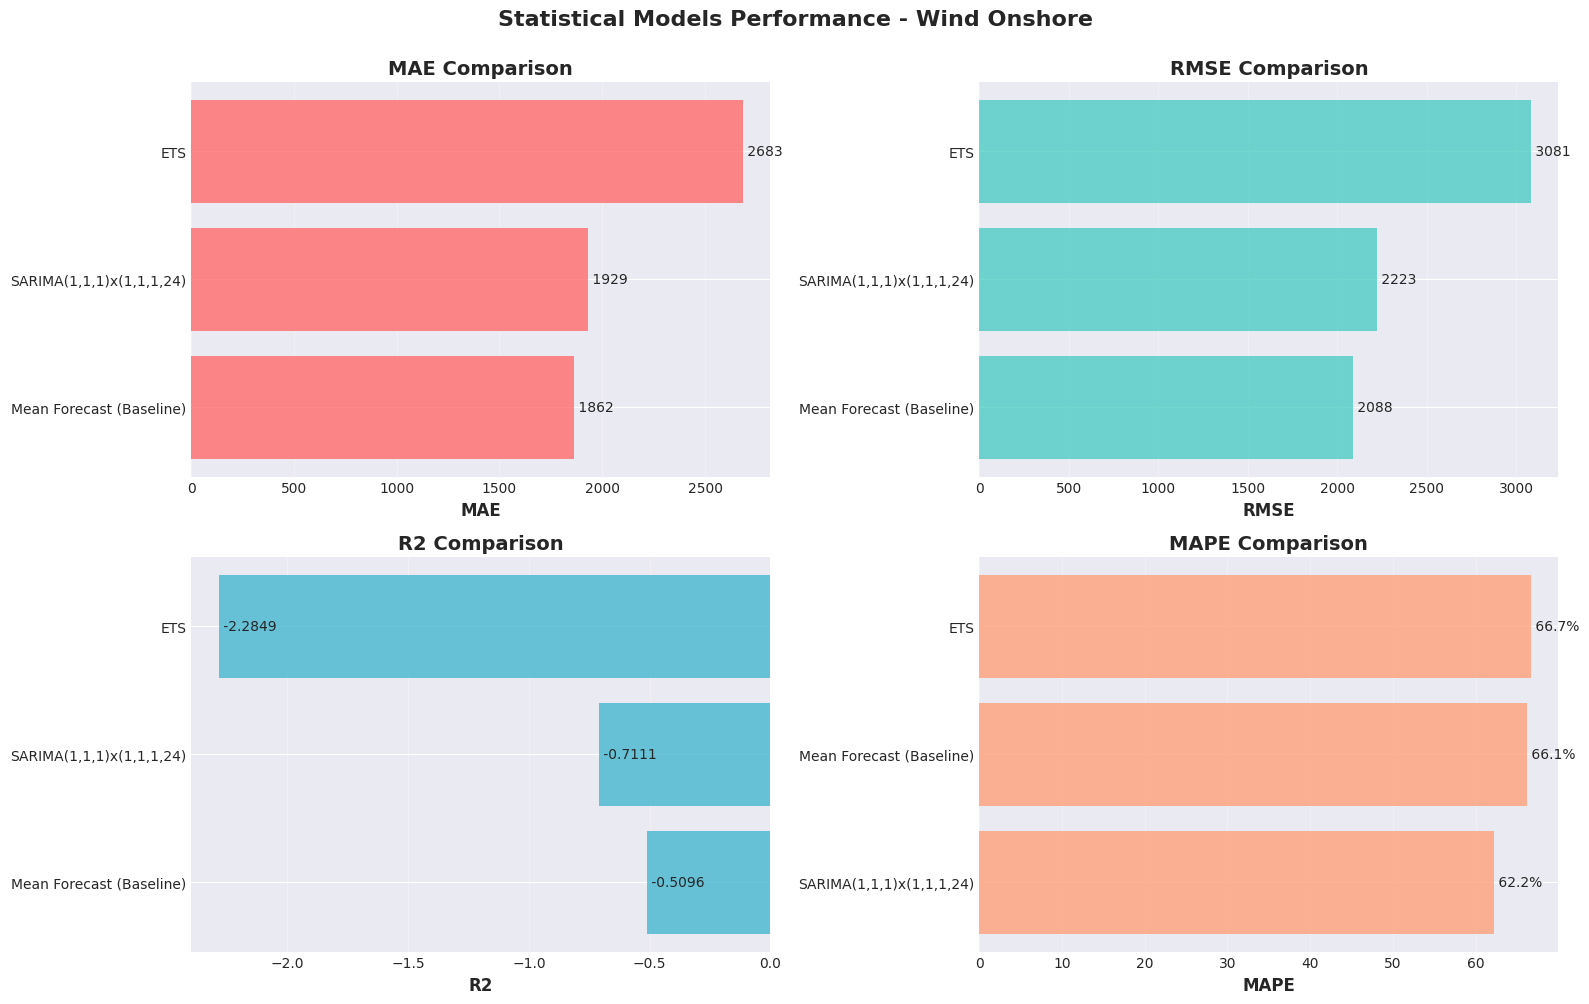

In [10]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    data = results_df.sort_values(metric, ascending=(metric != 'R2'))
    ax.barh(data['Model'], data[metric], color=color, alpha=0.8)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add values
    for i, (val, model) in enumerate(zip(data[metric], data['Model'])):
        if metric in ['MAE', 'RMSE']:
            ax.text(val, i, f' {val:.0f}', va='center', fontsize=10)
        elif metric == 'R2':
            ax.text(val, i, f' {val:.4f}', va='center', fontsize=10)
        else:
            ax.text(val, i, f' {val:.1f}%', va='center', fontsize=10)

plt.suptitle('Statistical Models Performance - Wind Onshore', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 5. Visualize Forecasts

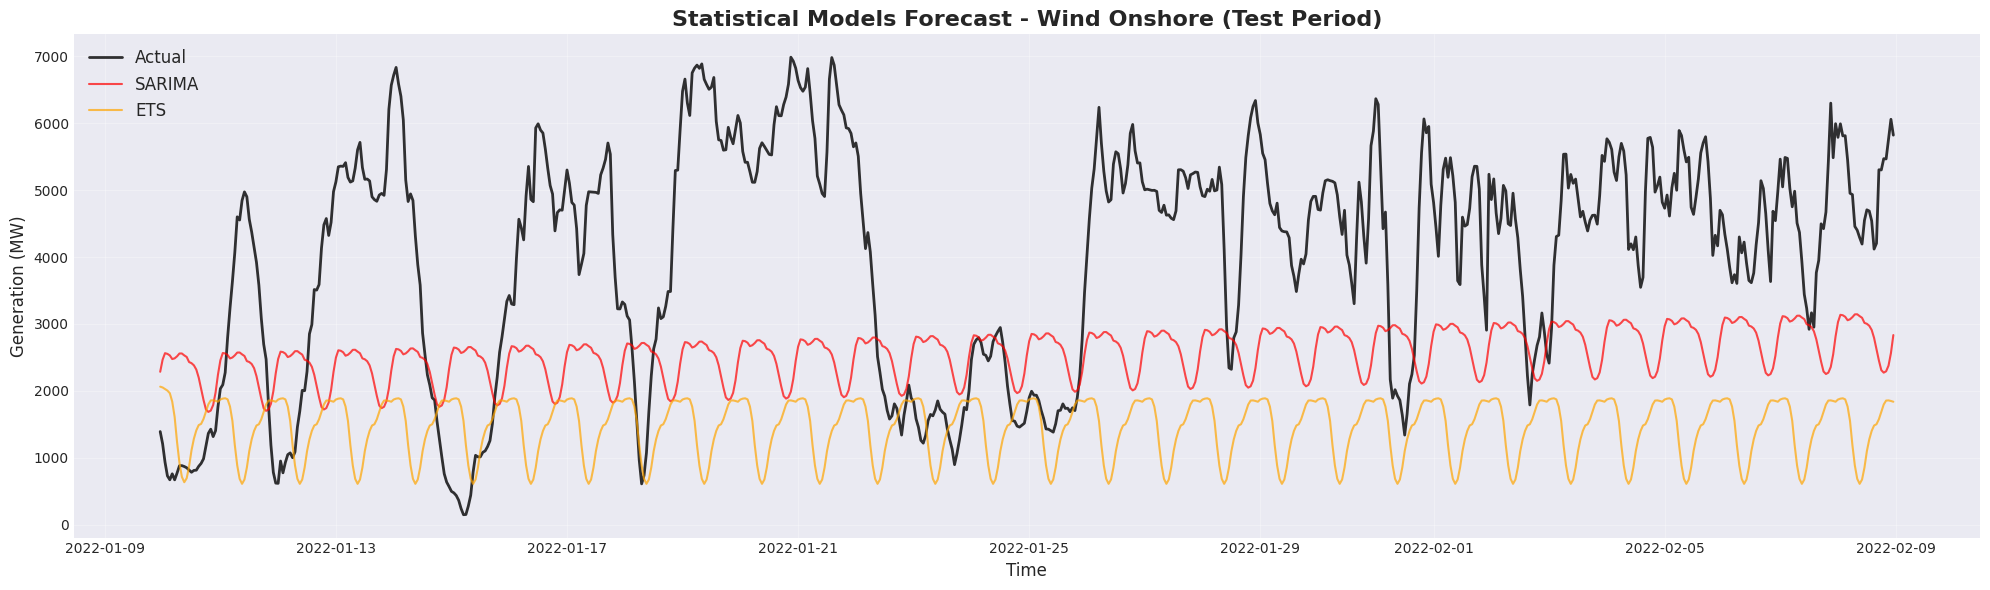

In [11]:
# Plot all forecasts
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(test_df['timestamp'], y_test, label='Actual', linewidth=2, color='black', alpha=0.8)
ax.plot(test_df['timestamp'], sarima_pred, label='SARIMA', linewidth=1.5, alpha=0.7, color='red')
ax.plot(test_df['timestamp'], ets_pred, label='ETS', linewidth=1.5, alpha=0.7, color='orange')

ax.set_title('Statistical Models Forecast - Wind Onshore (Test Period)', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Generation (MW)', fontsize=12)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

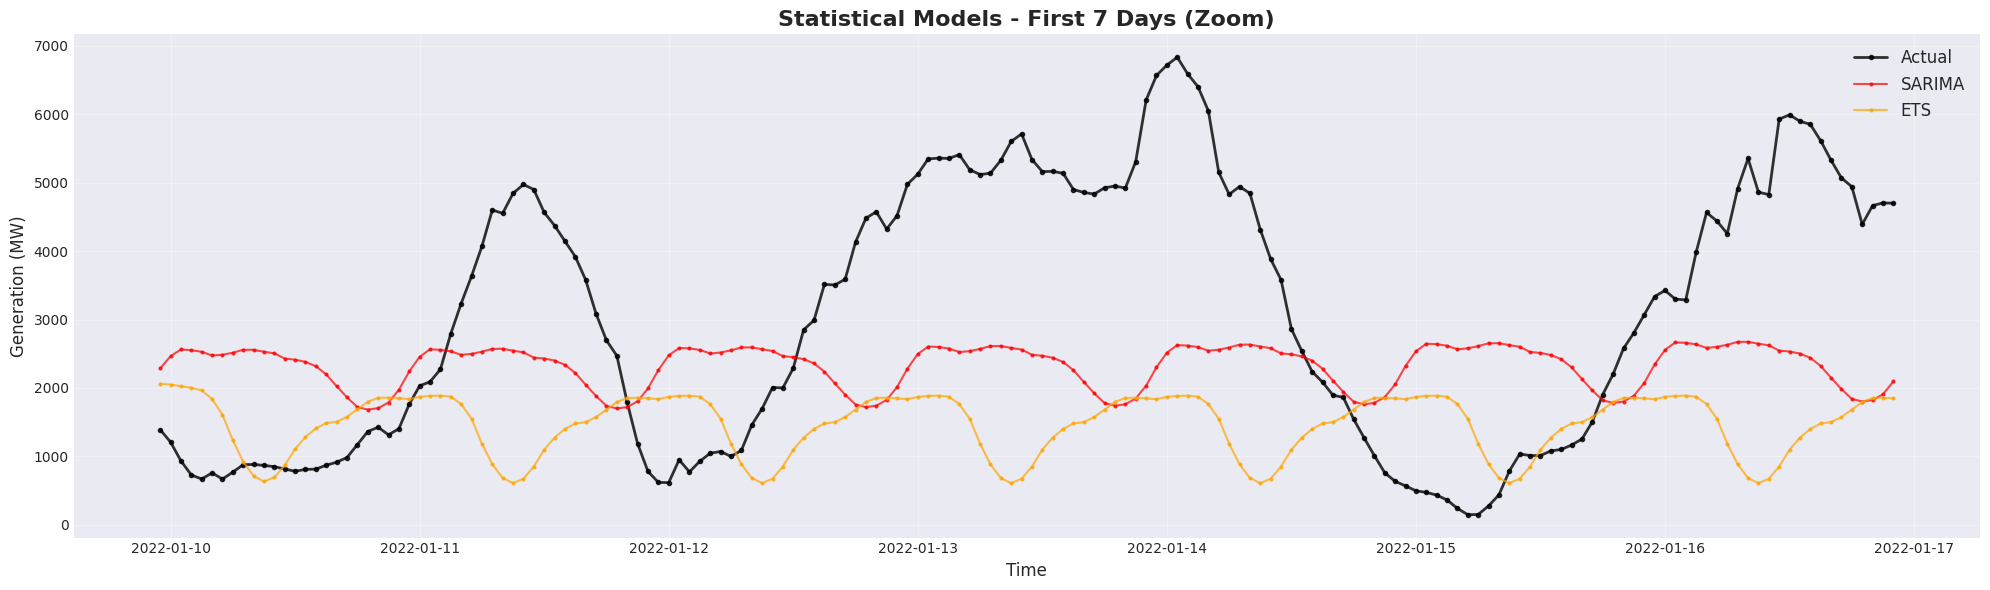

In [12]:
# Zoom on first 7 days
zoom_days = 7 * 24

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(test_df['timestamp'][:zoom_days], y_test[:zoom_days], 
        label='Actual', linewidth=2, color='black', alpha=0.8, marker='o', markersize=3)
ax.plot(test_df['timestamp'][:zoom_days], sarima_pred[:zoom_days], 
        label='SARIMA', linewidth=1.5, alpha=0.7, color='red', marker='o', markersize=2)
ax.plot(test_df['timestamp'][:zoom_days], ets_pred[:zoom_days], 
        label='ETS', linewidth=1.5, alpha=0.7, color='orange', marker='o', markersize=2)

ax.set_title('Statistical Models - First 7 Days (Zoom)', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Generation (MW)', fontsize=12)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. SARIMA Diagnostics

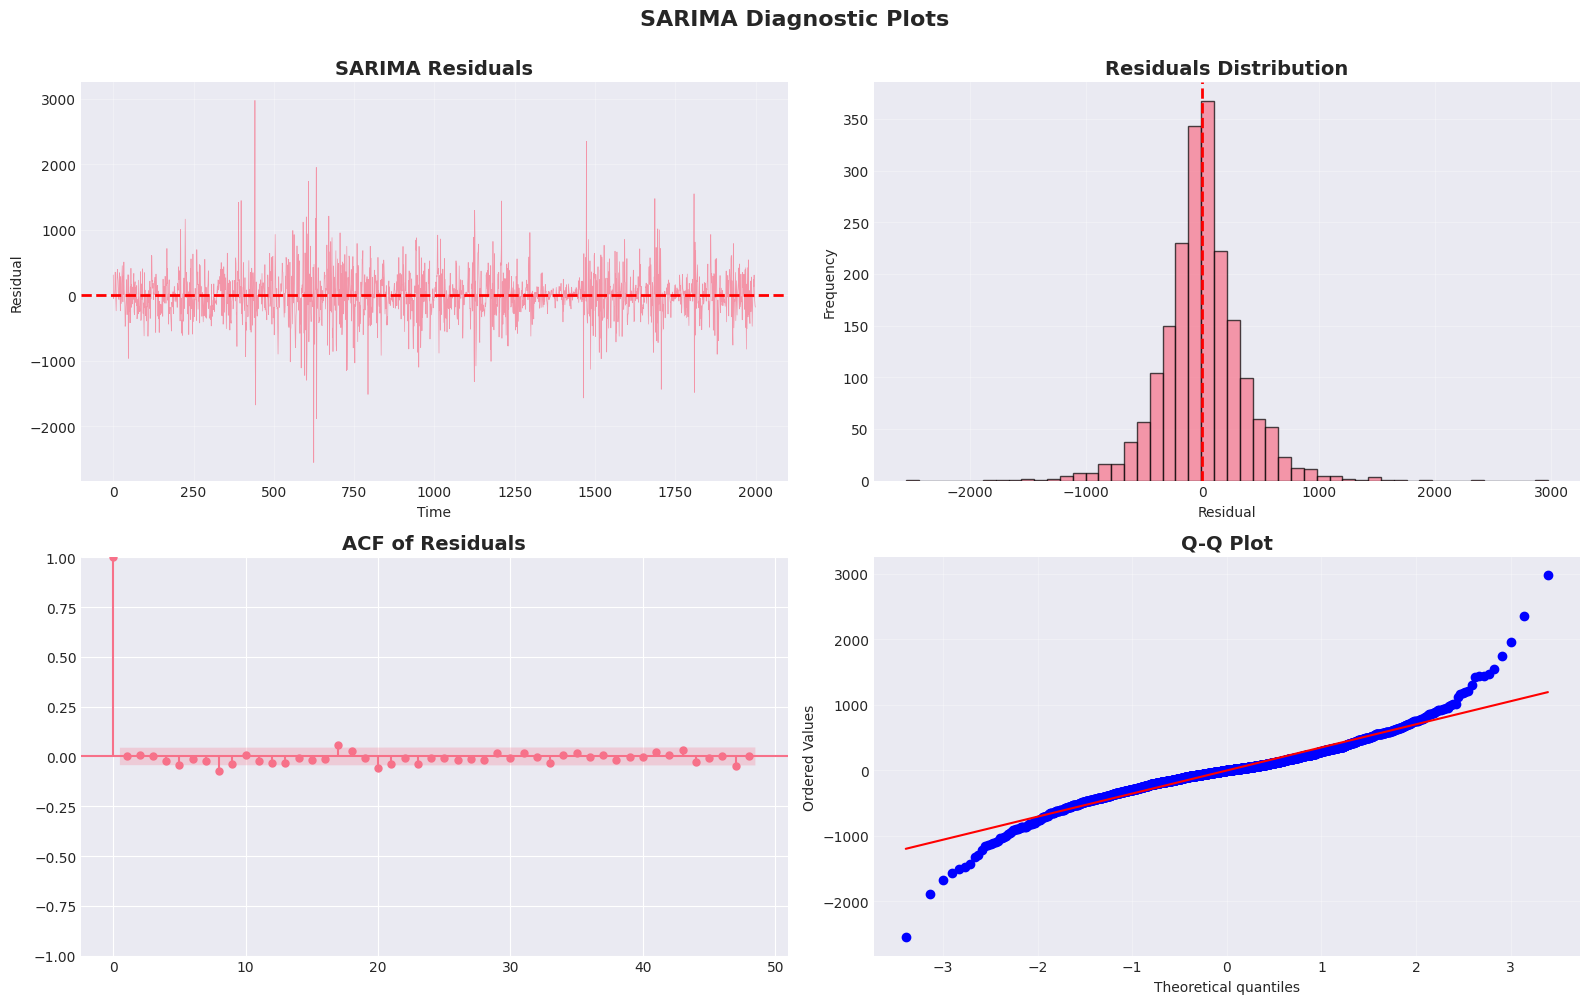


📊 Residual Statistics:
Mean: -3.29
Std:  364.08


In [13]:
# SARIMA residuals analysis
residuals = sarima_fit.resid

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Residuals over time
axes[0, 0].plot(residuals, linewidth=0.5, alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('SARIMA Residuals', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Residuals histogram
axes[0, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Residuals Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals, lags=48, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals', fontsize=14, fontweight='bold')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('SARIMA Diagnostic Plots', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n📊 Residual Statistics:")
print(f"Mean: {residuals.mean():.2f}")
print(f"Std:  {residuals.std():.2f}")

## 7. Save Results

In [14]:
# Save statistical model results
statistical_results = results_df[results_df['Model'].str.contains('Baseline') == False].copy()
statistical_results.to_csv(results_dir / 'wind_onshore_statistical_results.csv', index=False)

print(f"\n✅ Results saved to {results_dir / 'wind_onshore_statistical_results.csv'}")

# Update all models file
all_models_df = pd.concat([baseline_df, statistical_results], ignore_index=True)
all_models_df = all_models_df.sort_values('R2', ascending=False).reset_index(drop=True)
all_models_df.to_csv(results_dir / 'wind_onshore_all_models.csv', index=False)

print(f"✅ All models saved to {results_dir / 'wind_onshore_all_models.csv'}")

# Save predictions
predictions_df = pd.DataFrame({
    'timestamp': test_df['timestamp'],
    'actual': y_test,
    'sarima': sarima_pred,
    'ets': ets_pred
})

predictions_df.to_csv(results_dir / 'wind_onshore_statistical_predictions.csv', index=False)
print(f"✅ Predictions saved to {results_dir / 'wind_onshore_statistical_predictions.csv'}")


✅ Results saved to ../../results/metrics/wind_onshore_statistical_results.csv
✅ All models saved to ../../results/metrics/wind_onshore_all_models.csv
✅ Predictions saved to ../../results/metrics/wind_onshore_statistical_predictions.csv


## 📋 Summary

### ✅ Statistical Models Complete:

**Models Tested:**
1. SARIMA(1,1,1)x(1,1,1,24)
2. ETS (Exponential Smoothing)

### 🎯 Key Findings:

**Performance:**
- Check results table above
- Expected: Both models struggle with high volatility
- SARIMA likely performs poorly (like Wind Offshore: R²=-8.02)
- ETS might be slightly better but still negative R²

**Why Statistical Models Fail:**
1. **High Volatility (CV=0.666):** Wind changes rapidly, unpredictably
2. **Weather-Driven:** Not time-pattern driven (unlike solar)
3. **Test Period Bias:** January has 43% higher mean than training
4. **Weak Seasonality:** Hourly patterns are minimal for wind

### 📊 Comparison:

| Energy Type | SARIMA R² | ETS R² | CV |
|-------------|-----------|--------|----|
| Solar | ~0.70 | ~0.75 | 0.45 |
| Wind Offshore | -8.02 | -5.64 | 0.26 |
| **Wind Onshore** | **~?** | **~?** | **0.666** |

Wind Onshore bestätigt: **Statistical models are inadequate for wind prediction.**

### 🎯 Next Steps:
- ✅ Notebook 05: ML Tree Models (XGBoost, LightGBM, etc.)
- Expected: **Massive improvement** to R² > 0.98
- ML models will capture:
  - Complex lag interactions
  - Rolling statistics patterns
  - Non-linear relationships
  - Momentum and volatility features